In [2]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

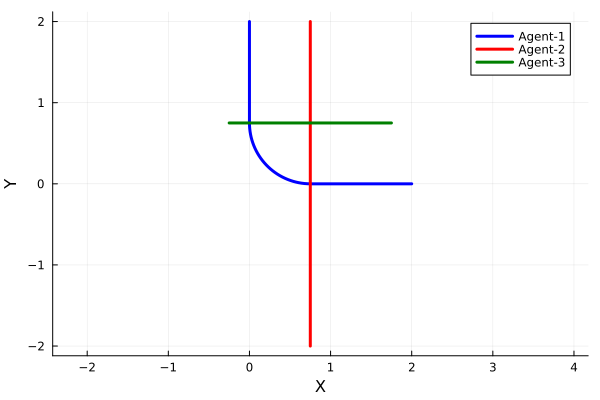

In [3]:
# Parameters
r = 0.75 # radius of the corner arc
n = 33   # number of points for each segment

# Vertical segment: from (0, 2) down to (0, r)
y_vals1 = range(2.0, stop=r, length=n)
x_vals1 = fill(0.0, n)
theta_vals1 = fill(-π/2, n)  # angle for vertical segment

# Quarter-circle arc (from down to right, clockwise)
θ_arc = range(π, stop=3*π/2, length=n+1)  # from left to down
x_arc = r * cos.(θ_arc)
y_arc = r * sin.(θ_arc)
theta_arc = θ_arc .- 3*π/2  # adjust angle to be clockwise

# Shift arc to connect at (0, r)
x_arc_shifted = x_arc .+ r
y_arc_shifted = y_arc .+ r

# Horizontal segment: from (0, r) to (3, r)
x_vals2 = range(r, stop=2.0, length=n+1)
y_vals2 = fill(0, n+1)
theta_vals3 = fill(0.0, n+1)  # angle for horizontal segment

# Combine all segments
x_all_1 = vcat(x_vals1, x_arc_shifted, x_vals2)
y_all_1 = vcat(y_vals1, y_arc_shifted, y_vals2)
theta_all_1 = vcat(theta_vals1, theta_arc, theta_vals3)

x_all_2 = fill(0.75,101)
y_all_2 = range(-2, stop=2, length=101)
theta_all_2 = fill(π/2, 101)

x_all_3 = range(-0.25,1.75,length=101)
y_all_3 = fill(0.75, 101)
theta_all_3 = fill(0.0, 101)


# Plot
plot(x_all_1, y_all_1, lw=3, c=:blue, label="Agent-1")
plot!(x_all_2, y_all_2, lw=3, c=:red, label="Agent-2")
plot!(x_all_3, y_all_3, lw=3, c=:green, label="Agent-3")
# scatter!([0.0], [2.0], label="Start", color=:green)
# scatter!([2.0], [0], label="End", color=:red)
xlabel!("X")
ylabel!("Y")
# keep aspect ratio square
aspect_ratio = 1
plot!(aspect_ratio=aspect_ratio, legend=:topright)
plot!()

In [4]:
function uni_dyna(x,u)
    return [x[1]+dt*u[1]*cos(x[3]), x[2]+dt*u[1]*sin(x[3]), x[3]+dt*u[2]]
end

N = 100
n_x = 9
n_u = 6
state_dimension = 3
control_dimension = 2
horizon = N
tf = 10.
dt = tf/(N)
u1_b = 0.15
u2_b = 0.75

xo = @SVector [5.0,10.0*sin(pi/3)/3]
ro = 1.55
ra = 0.75

Q = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 50, 10, 5, 5, 5, 5, 2, 2, 2])*0.6 # This is reference tracking and control cost
Qf = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 50, 10, 5, 5, 5, 5, 2, 2, 2])*50
R = Diagonal(@SVector [10, 10, 10, 5, 5, 5])*0.8

noise_level = 0.3

full_traj = []

num_sim = 100

sim = 1

while sim<=num_sim

    x0 = [0,2,-π/2, 0.5, -2, π/2, -0.25, 0.75, 0] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    xf = [2.0, 0, 0, 0.5, 2, π/2, 1.75, 0.75, 0] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    x_vals2 = range(r, stop=xf[1], length=n+1)
    y_vals2 = range(0, stop=xf[2], length=n+1)

    x_all_1 = vcat(x_vals1, x_arc_shifted, x_vals2)
    y_all_1 = vcat(y_vals1, y_arc_shifted, y_vals2)

    x_all_2 = range(x0[4], stop=xf[4], length=101)
    y_all_2 = range(x0[5], stop=xf[5], length=101)
    x_all_3 = range(x0[7], stop=xf[7], length=101)
    y_all_3 = range(x0[8], stop=xf[8], length=101)
    

    # x0 = [0,0,pi/6,10,0,pi-pi/6,10*cos(pi/3),10*sin(pi/3), -pi/2] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]
    # xf = [10*cos(pi/6),10*sin(pi/6),pi/6,
    # 10-10*cos(pi/6),10*sin(pi/6),pi - pi/6,
    # 10*cos(pi/3),10*sin(pi/3)-10, -pi/2] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    # xf2 = @SVector [20,-2,0,0,-2,pi]

    X_ref = hcat(x_all_1, y_all_1, theta_all_1,
                x_all_2, y_all_2, theta_all_2,
                x_all_3, y_all_3, theta_all_3,
                zeros(N+1), zeros(N+1), zeros(N+1), zeros(N+1), zeros(N+1), zeros(N+1))

    problem_size = N*(n_x+n_u)

    model = Model(Ipopt.Optimizer)

    @variable(model, x11[1:N+1])
    @variable(model, x12[1:N+1])
    @variable(model, x13[1:N+1])
    @variable(model, x21[1:N+1])
    @variable(model, x22[1:N+1])
    @variable(model, x23[1:N+1])
    @variable(model, x31[1:N+1])
    @variable(model, x32[1:N+1])
    @variable(model, x33[1:N+1])

    @variable(model, 0<=u11[1:N+1])
    @variable(model, u12[1:N+1]);
    @variable(model, 0<=u21[1:N+1])
    @variable(model, u22[1:N+1]);
    @variable(model, 0<=u31[1:N+1])
    @variable(model, u32[1:N+1]);

    @variable(model, -u1_b <= du11[1:N+1] <= u1_b)
    @variable(model, -u2_b <= du12[1:N+1] <= u2_b);
    @variable(model, -u1_b <= du21[1:N+1] <= u1_b)
    @variable(model, -u2_b <= du22[1:N+1] <= u2_b);
    @variable(model, -u1_b/5 <= du31[1:N+1] <= u1_b/5)
    @variable(model, -u2_b <= du32[1:N+1] <= u2_b);

    fix(x11[1],x0[1],force=true)
    fix(x12[1],x0[2],force=true)
    fix(x13[1],x0[3],force=true)
    fix(x21[1],x0[4],force=true)
    fix(x22[1],x0[5],force=true)
    fix(x23[1],x0[6],force=true)
    fix(x31[1],x0[7],force=true)
    fix(x32[1],x0[8],force=true)
    fix(x33[1],x0[9],force=true)

    fix(u11[N+1],0.0,force=true)
    fix(u12[N+1],0.0,force=true)
    fix(u21[N+1],0.0,force=true)
    fix(u22[N+1],0.0,force=true)
    fix(u31[N+1],0.0,force=true)
    fix(u32[N+1],0.0,force=true)

    fix(du11[N+1],0.0,force=true)
    fix(du12[N+1],0.0,force=true)
    fix(du21[N+1],0.0,force=true)
    fix(du22[N+1],0.0,force=true)
    fix(du31[N+1],0.0,force=true)
    fix(du32[N+1],0.0,force=true)

    X_full= vcat(x11',x12',x13',x21',x22',x23',x31',x32',x33',u11',u21',u31',u12',u22',u32')

    U_full = vcat(u11',u21',u31',u12',u22',u32')

    @objective(model, Min, tr((X_full'[1:N,:] - X_ref[1:N,:])*Q*(X_full[:,1:N] - X_ref'[:,1:N])) + tr(U_full'*R*U_full) + (X_full'[1+N,:] - X_ref[1+N,:])'*Qf*(X_full[:,1+N] - X_ref'[:,1+N]))

    @constraint(model, [t in 1:N], uni_dyna([x11[t],x12[t],x13[t]],[u11[t],u12[t]]) == [x11[t+1],x12[t+1],x13[t+1]]);
    @constraint(model, [t in 1:N], uni_dyna([x21[t],x22[t],x23[t]],[u21[t],u22[t]]) == [x21[t+1],x22[t+1],x23[t+1]]);
    @constraint(model, [t in 1:N], uni_dyna([x31[t],x32[t],x33[t]],[u31[t],u32[t]]) == [x31[t+1],x32[t+1],x33[t+1]]);
    @constraint(model, [t in 1:N], [u21[t]+du21[t+1],u22[t]+du22[t+1]] == [u21[t+1],u22[t+1]]);
    @constraint(model, [t in 1:N], [u11[t]+du11[t+1],u12[t]+du12[t+1]] == [u11[t+1],u12[t+1]]);
    @constraint(model, [t in 1:N], [u31[t]+du31[t+1],u32[t]+du32[t+1]] == [u31[t+1],u32[t+1]]);
    @constraint(model, [t in 1:N+1], (x21[t] - x11[t])^2 + (x22[t] - x12[t])^2 - ra^2 >= 0);
    @constraint(model, [t in 1:N+1], (x31[t] - x11[t])^2 + (x32[t] - x12[t])^2 - ra^2 >= 0);
    @constraint(model, [t in 1:N+1], (x31[t] - x21[t])^2 + (x32[t] - x22[t])^2 - ra^2 >= 0);
    # @constraint(model, [t in 1:N+1], (xo[1] - x11[t])^2 + (xo[2] - x12[t])^2 - ro^2 >= 0);
    # @constraint(model, [t in 1:N+1], (xo[1] - x21[t])^2 + (xo[2] - x22[t])^2 - ro^2 >= 0);
    # @constraint(model, [t in 1:N+1], (xo[1] - x31[t])^2 + (xo[2] - x32[t])^2 - ro^2 >= 0);

    for i in 1:N+1
        set_start_value(x11[i],X_ref[i,1]+ 0.1*(2*rand()-1))
        set_start_value(x12[i],X_ref[i,2]+ 0.1*(2*rand()-1))
        set_start_value(x13[i],X_ref[i,3]+ 0.1*(2*rand()-1))
        set_start_value(x21[i],X_ref[i,4]+ 0.1*(2*rand()-1))
        set_start_value(x22[i],X_ref[i,5]+ 0.1*(2*rand()-1))
        set_start_value(x23[i],X_ref[i,6]+ 0.1*(2*rand()-1))
        set_start_value(x31[i],X_ref[i,7]+ 0.1*(2*rand()-1))
        set_start_value(x32[i],X_ref[i,8]+ 0.1*(2*rand()-1))
        set_start_value(x33[i],X_ref[i,9]+ 0.1*(2*rand()-1))

        set_start_value(u11[i],X_ref[i,10])
        set_start_value(u21[i],X_ref[i,11])
        set_start_value(u31[i],X_ref[i,12])
        set_start_value(u12[i],X_ref[i,13])
        set_start_value(u22[i],X_ref[i,14])
        set_start_value(u32[i],X_ref[i,15])

        set_start_value(du11[i],0.0)
        set_start_value(du12[i],0.0)
        set_start_value(du21[i],0.0)
        set_start_value(du22[i],0.0)
        set_start_value(du31[i],0.0)
        set_start_value(du32[i],0.0)
        
    end

    optimize!(model)

    if is_solved_and_feasible(model)

        X1 = hcat(value.(x11),value.(x12),value.(x13))
        X2 = hcat(value.(x21),value.(x22),value.(x23))
        X3 = hcat(value.(x31),value.(x32),value.(x33))

        traj = hcat(value.(u11),value.(u12),value.(u21),value.(u22), value.(u31),value.(u32),
                    value.(x11),value.(x12),value.(x13), 
                    value.(x21),value.(x22),value.(x23),
                    value.(x31),value.(x32),value.(x33))

        # if maximum(X1[:,2]) < 5.5 && maximum(X2[:,2]) < 5.5 && minimum(X1[:,2]) > -1 && minimum(X2[:,2]) > -1

        if sim == 1
            full_traj = traj[1:100,:]
            Plots.plot(X1[:,1],X1[:,2],color="blue",label="Agent 1")
            Plots.plot!(X2[:,1],X2[:,2],color="orange",label="Agent 2")
            Plots.plot!(X3[:,1],X3[:,2],color="green",label="Agent 3")
            # Plots.plot(circleShape(xo[1], xo[2], ro), seriestype = [:shape, ], lw=0.5, c = :gray, linecolor = :white, legend = false, fillalpha = 0.2, aspect_ratio = 1)
        else
            full_traj = vcat(full_traj,traj[1:100,:])
            Plots.plot!(X1[:,1],X1[:,2],color = "blue",label="")
            Plots.plot!(X2[:,1],X2[:,2],color="orange",label="")
            Plots.plot!(X3[:,1],X3[:,2],color="green",label="")
        end
        sim += 1
        if sim % 10 == 0
            println("Simulation $sim completed")
        end
    end 
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     5073
Number of nonzeros in inequality constraint Jacobian.:     2400
Number of nonzeros in Lagrangian Hessian.............:     5088

Total number of variables............................:     2100
                     variables with only lower bounds:      300
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1500
Total number of inequality c

Excessive output truncated after 536553 bytes.

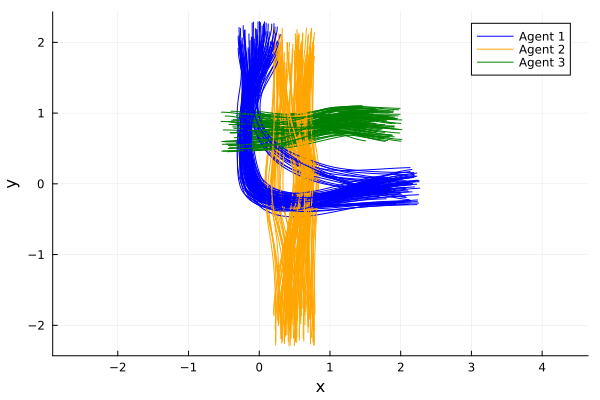

In [6]:
# Plots.plot!(circleShape(xo[1], xo[2], ro), seriestype = [:shape, ], lw=0.5, c = :gray, linecolor = :white, legend = false, fillalpha = 0.2, aspect_ratio = 1)
Plots.xlabel!("x")
Plots.ylabel!("y")
# make the aspect_ratio 1
plot!(aspect_ratio=aspect_ratio, legend=:topright)

In [7]:
size(full_traj,1)

10000

In [9]:
CSV.write("data/three_agents_trajs_highway_noise_0_3.csv", Tables.table(full_traj), writeheader=false)

"data/three_agents_trajs_highway_noise_0_3.csv"

Plots.AnimatedGif("/Users/maulik/Documents/Sem-8/CTDE_Diffusion/base/multi_agent_trajectory.gif")
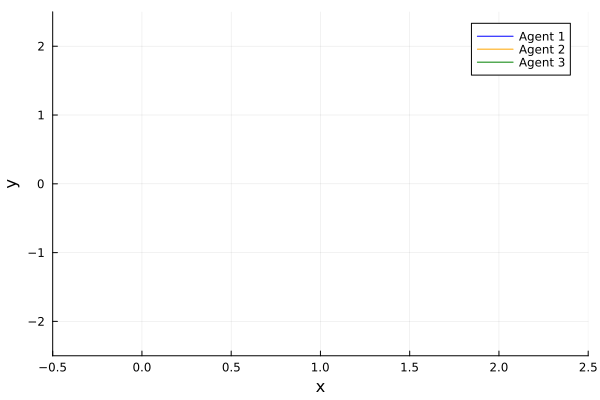

In [10]:
# plot gif of the last trajectory
n = 43
anim = @animate for i in 1:100
    Plots.plot(full_traj[1+100*(n-1):i+100*(n-1),7], full_traj[1+100*(n-1):i+100*(n-1),8], color="blue", label="Agent 1")
    Plots.plot!(full_traj[1+100*(n-1):i+100*(n-1),10], full_traj[1+100*(n-1):i+100*(n-1),11], color="orange", label="Agent 2")
    Plots.plot!(full_traj[1+100*(n-1):i+100*(n-1),13], full_traj[1+100*(n-1):i+100*(n-1),14], color="green", label="Agent 3")
    Plots.xlabel!("x")
    Plots.ylabel!("y")
    Plots.xlims!(-0.5, 2.5)
    Plots.ylims!(-2.5, 2.5)
    # Plots.plot!(aspect_ratio=aspect_ratio, legend=:topright)
end

gif(anim, "multi_agent_trajectory.gif", fps=30)

In [11]:
# compute argmin of full_traj[:,10]
argmin(full_traj[:,10])/100

36.62